In [4]:
#standard packages
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from labellines import labelLine, labelLines

#administrative packages
import os
import datetime
mydate = datetime.datetime.now()
from datetime import date,timedelta
import time
start = time.time()

holidays = [
    '2017-01-02',
    '2017-01-16',
    '2017-02-20',
    '2017-05-29',
    '2017-07-04',
    '2017-09-04',
    '2017-11-10',
    '2017-11-23',
    '2017-11-24',
    '2017-12-22',
    '2017-12-25',
    '2017-12-26',
    '2017-12-27',
    '2017-12-28',
    '2017-12-29',
    '2018-01-01',
    '2018-01-15',
    '2018-02-19',
    '2018-04-28',
    '2018-07-04',
    '2018-09-03',
    '2018-11-12',
    '2018-11-22',
    '2018-11-23',
    '2018-12-24',
    '2018-12-25',
    '2018-12-26',
    '2018-12-27',
    '2018-12-28',
    '2018-12-31',
    '2019-01-01',
    '2019-01-21',
    '2019-02-18',
    '2019-05-27',
    '2019-07-04',
    '2019-09-02',
    '2019-11-11',
    '2019-11-28',
    '2019-11-29',
    '2019-12-24',
    '2019-12-25',
    '2019-12-26',
    '2019-12-27',
    '2019-12-30',
    '2019-12-31',
    '2020-01-01',
    '2020-01-20',
    '2020-02-17',
    '2020-05-25',
    '2020-07-03',
    '2020-09-07',
    '2020-11-11',
    '2020-11-26',
    '2020-11-27',
    '2020-12-24',
    '2020-12-25',
    '2020-12-28',
    '2020-12-29',
    '2020-12-30',
    '2020-12-31',
    '2020-12-01'
]
holidays = set([pd.Timestamp(h) for h in holidays])

In [5]:
local_folder = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting'
#local_folder = r'C:\Users\nelms\Dropbox\Python\WC'
os.chdir(local_folder)

In [6]:
tit= 'Commercial Alteration'

less, great = ((pd.to_datetime('2017Q4')).to_period('Q'), (pd.to_datetime('2020Q1')).to_period('Q'))

BUILD = {
    'Application Submittal - Route':'Start',
    'Consolidated Comments - With Customer for Response':'Round_End',
    'Consolidated Comments - Resubmittal':'Round_Start',
    'Ready to Issue - Issued':'End'
}

types = {
    'Commercial Alteration':BUILD
}

stat_d = types[tit]

def prepare_times(path, dyct=stat_d, prep=False, sdp=False):
    spd = False or sdp
    dyct = dyct or stat_d
    prep = prep or False
    temp = pd.read_csv(path, skiprows=1)
    if sdp == True:
        temp = temp[temp['Record Type']=='Site Development Permit']
    temp = temp[['Permit #', 'Task', 'Status', 'DATE ASSIGNED', 'UPDATED DATE']].rename(columns={'Permit #':'#'})
    temp['Task Status'] = temp['Task'] + ' - ' + temp['Status']
    temp.drop_duplicates(inplace=True, keep='first')
    if prep == True:
        temp = temp.loc[(temp['Task Status'].isin(dyct.keys()))]
    temp = temp.set_index(['#', 'Task Status'])
    temp.sort_values(['#','UPDATED DATE'], inplace=True)
    if prep == True:
        temp.drop(['Task','Status'], axis=1,inplace=True)
    temp['DATE ASSIGNED'] = pd.to_datetime(temp['DATE ASSIGNED'])
    temp['UPDATED DATE'] = pd.to_datetime(temp['UPDATED DATE'])
    temp.sort_values(['#','UPDATED DATE'], inplace=True)
    return temp

def sum_days(strt, nd, busi=True):
    if busi ==True:
        days = [d for d in pd.bdate_range(start=strt, end=nd).to_list() if d not in holidays]
    if busi == False:
        days = pd.date_range(start=strt, end=nd).to_list()
    return days

def check_days(srt, ned, a_list, t_list):
    s = [ss for ss in sum_days(srt, ned, busi=True) if ss not in t_list]
    t_list.update(s)
    a_list.append(len(s))
    return a_list, t_list

def get_rec_list(rec, parcs):
    temp = parcs.xs(rec).sort_values('UPDATED DATE').copy()
    temp.index = temp.index.map(stat_d)
    temp.reset_index(inplace=True)
    return temp.values.tolist()

def count_days(rec, parcs):
    try:
        ts = get_rec_list(rec, parcs)

        #print(rec)

        start = ts[0][1]
        receive = ts[0][2]
        if start == receive:
            route_time = 0
        else:
            route_time = len(sum_days(start, receive, busi=True))
        end = ts[-1][2]
        total_days = sum_days(start, end)

        if 'Start' == ts[0][0]:
            ts.pop(0)
        elif 'End' == ts[0][0]:
            s = False
            curr_end = ts[0][2]
        curr_start = start
        work_days = []
        temp_days = set()
        tsl = len(ts)
        check = 0
        next_step = ts[0][0]
        place = True

        while tsl > 1:       

            if check > 20:
                print('over check 20 ', next_step, rec, ts)
                break

            if next_step == 'Round_End':
                if place != False:
                    curr_end = ts[0][2]
                    ts.pop(0)
                #print(curr_start, curr_end)
                s = False
                work_days, temp_days = check_days(curr_start, curr_end, work_days, temp_days)
                tsl = len(ts)

                place = True

            next_step = ts[0][0]

            if next_step == 'Round_End':
                curr_start = ts[0][1]
                tsl = len(ts)
                place = True

            next_step = ts[0][0]

            if next_step == 'Round_Start':
                curr_start = ts[0][2]
                #print('round start', next_step)
                if len(ts) == 2:
                    temp_start = ts[0][2]

                ts.pop(0)

                tsl = len(ts)

                s = True

                place = True

            next_step = ts[0][0]

            if next_step == 'Round_Start':
                #print('double Round Start')
                curr_end = ts[0][1]

                if len(ts) == 2:
                    temp_start = ts[0][2]
                    ts.pop(0)

                place = False

                s = True

            tsl = len(ts)
            check = check + 1

        if s == True:
            curr_start = temp_start
            endend = ts[0][2]
            work_days, temp_days = check_days(curr_start, endend, work_days, temp_days)
            #print(check, work_days[-1], curr_start, curr_end)
        else:
            if ts[0][2] != curr_end:
                work_days.append(1)
                #print(check, work_days[-1], '               ', curr_end)
            elif 'End' == ts[0][0]:
                work_days.append(1)
            else:
                work_days.append(0)
                #print(check, work_days[-1], '               ', curr_end)
        #print(len(total_days), sum(work_days), len(work_days), route_time, work_days)
        return len(total_days), sum(work_days), len(work_days), route_time, work_days, start, end
    except:
        print(rec, parcs)
        pass

def count_oneday(rec, parcs):
    ts = get_rec_list(rec, parcs)
    
    start = ts[0][1]
    receive = ts[0][2]
    if start == receive:
        route_time = 1
    else:
        route_time = len(sum_days(start, receive, busi=True))
    total_days = sum_days(start, receive)
    
    return len(total_days), route_time, 1, 0, [route_time], start, receive

def count_twoday(rec, parcs):
    ts = get_rec_list(rec, parcs)
    
    start = ts[0][1]
    receive = ts[0][2]
    if start == receive:
        route_time = 1
    else:
        route_time = len(sum_days(start, receive, busi=True))
    end = ts[-1][2]
    total_days = sum_days(start, end)
    
    curr_start = ts[1][1]
    if curr_start == receive:
        second_time = 0
    else:
        second_time = len(sum_days(curr_start, end, busi=True))
    
    work_days = [route_time, second_time]
    
    return len(total_days), sum(work_days), 2, route_time, work_days, start, end

def get_counts(parcs):
    amts = parcs.reset_index().groupby('#')['Task Status'].count()
    div = 2
    large = set(amts[amts > div].index)
    mid = set(amts[amts == div].index)
    small = set(amts[amts < div].index)

    OneDay = parcs.loc[parcs.index.get_level_values('#').isin(small)].sort_values(['#','UPDATED DATE'])
    DuoDay = parcs.loc[parcs.index.get_level_values('#').isin(mid)].sort_values(['#','UPDATED DATE'])
    MultiDay = parcs.loc[parcs.index.get_level_values('#').isin(large)].sort_values(['#','UPDATED DATE'])
    sum_l = []
    if len(large) > 0:
        try:
            e = [sum_l.append([ids] + 
                              list(count_days(ids, parcs))) 
                 for ids in large if type(ids) != type(None)]
        except:
            for ids in large:
                try:
                    sum_l.append([ids] + list(count_days(ids, parcs)))
                except:
                    print(ids)
    if len(mid) > 0:
        e = [sum_l.append([ids] + 
                          list(count_twoday(ids, parcs))) 
             for ids in mid]
    if len(small) > 0:
        e = [sum_l.append([ids] + list(count_oneday(ids, parcs))) for ids in small]
    return pd.DataFrame(sum_l, columns=['Record #', 'Total Days', 'Working Days', 'Rounds', 'Days till Routing', 'Days per Round', 'Submittal Date', 'Complete Date']).set_index('Record #')

def join_cates(old, new_path):
    temp = pd.read_csv(new_path, skiprows=1)[['Permit #',
                                             'Type of Work',
                                             #'Subtype',
                                             'CONST TYPE CODE',
                                             'Description']].rename(columns={'Permit #':'#', 'CONST TYPE CODE':'Con Code'})
    temp.drop_duplicates(inplace=True, keep='first')
    temp = temp.set_index(['#'])
    
    file_name = r'ConstCodes.csv'
    path = os.path.join(os.getcwd(), file_name)
    const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
    temp['Con Desc'] = temp['Con Code'].map(const_dict)
    return temp.join(old, how='outer', rsuffix='desc')

def get_reviews(path, let=False):
    let = let or False
    bb = prepare_times(path, prep=False)
    bbb = bb.loc[(bb['Task'].str.contains('Review'))&(bb['Status']=='Routed')].reset_index()[['#','Task Status', 'Task']].groupby(['#','Task Status']).count()
    bbbi = set(bbb.index.get_level_values(0))

    if let == True:
        bb_dict = {b:[''.join(sorted([b[0] for b in bbb.xs(b).index.values]))] for b in bbbi}
    else:
        bb_dict = {b:[len(bbb.xs(b))] for b in bbbi}

    tl = 1
    while len(bbb.loc[bbb['Task']>tl, 'Task']):
        if let == True:
            [bb_dict[b].append(''.join(sorted([b[0] for b in bbb.loc[bbb['Task']>tl].xs(b).index.values]))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        else:
            [bb_dict[b].append(len(bbb.loc[bbb['Task']>tl].xs(b))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        tl = tl + 1
    return bb_dict

file_name = r'BlueTest_Building_TI_1719.csv'
path = os.path.join(os.getcwd(), file_name)
BTI = prepare_times(path, prep=True)
BTI = get_counts(BTI)
BTI = BTI[(BTI['Complete Date'].dt.to_period('Q') > less)&(BTI['Complete Date'].dt.to_period('Q') < great)]
BTI['Reviews'] = BTI.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_Const.csv'
#path = os.path.join(os.getcwd(), file_name)
#BCo = prepare_times(path, prep=True)
#BCo = get_counts(BCo)
#BCo = join_cates(BCo, path)
#BCo['Reviews'] = BCo.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_B_SDP.csv'
#path = os.path.join(os.getcwd(), file_name)
#SDP = prepare_times(path, prep=True, sdp=True)
#SDP = get_counts(SDP)

#SDP = join_cates(SDP, path)
#SDP['Reviews'] = SDP.index.map(get_reviews(path, let=True)).fillna(value=0)

over check 20  End B170604 [['End', Timestamp('2017-07-31 00:00:00'), Timestamp('2017-08-07 00:00:00')], ['End', Timestamp('2017-07-31 00:00:00'), Timestamp('2017-08-14 00:00:00')]]
B170604                                                            DATE ASSIGNED  \
#       Task Status                                                        
B161424 Application Submittal - Route                         2016-07-21   
        Consolidated Comments - With Customer for Response    2016-08-11   
        Consolidated Comments - Resubmittal                   2016-08-11   
        Ready to Issue - Issued                               2016-08-31   
B161636 Application Submittal - Route                         2016-08-22   
...                                                                  ...   
B191937 Application Submittal - Route                         2019-12-17   
        Ready to Issue - Issued                               2019-12-17   
B191938 Ready to Issue - Issued                   

In [7]:
BTI['Complete Date'].max()

Timestamp('2019-12-19 00:00:00')

# Analysis

In [8]:
def grping(layer, grp_fld, rn, All = True):
    All = True or All
    agg_base = ['mean']
    layer['Permits'] = 1
    keep =['Working Days', 'Rounds', 'Days till Routing']
    rename_keep = {'Permits':'# of Permits', 'Working Days':'Avg # of Working Days', 'Rounds':'Avg # of Rounds', 'Days till Routing':'Avg # of Days till Routing'}
    
    aggs = {k:agg_base for k in keep}
    aggs['Permits'] = ['count']
    
    keep = ['Permits'] + keep
    
    b = layer.groupby(grp_fld).agg(aggs).astype(int)
    
    b.index = b.index.map(rn)
    if All == True:
        pass
    else:
        c = layer[keep].groupby([True]*len(layer)).agg(aggs).astype(int).rename({True:'All'}, axis=0)
        b = c.append(b[keep])
    b = b[keep].rename(columns=rename_keep, level=0)
    b.columns = b.columns.droplevel(level=1)
    
    layer.drop(columns='Permits', inplace=True)
        
    return b

def create_tempBTI(filtBTI):
    tempBTI = filtBTI.copy()
    if max(tempBTI['Rounds']) > 3:
        r2l = [1,2,3,max(tempBTI['Rounds'])]
        r2d = {
                    0 : "2 Rounds",
                    1 : "3 Rounds",
                    2 : "4 Rounds or More"
                }
    elif max(tempBTI['Rounds']) == 3:
        r2l = [1,2,3]
        r2d = {
                    0 : "2 Rounds",
                    1 : "3 Rounds"
                }
    elif max(tempBTI['Rounds']) < 3:
        r2l = [1,2]
        r2d = {
                    0 : "2 Rounds"
                }
    grp_by = [pd.cut(tempBTI['Rounds'], r2l, labels=False)]
    tempBTI_avg = grping(tempBTI, grp_by, r2d)

    
    if max(tempBTI.loc[tempBTI['Rounds']==1, 'Working Days']) == 1:
        r1l = [0,1]
    else:
        r1l = [0,1,max(tempBTI.loc[tempBTI['Rounds']==1, 'Working Days'])]
    grp_by = [pd.cut(tempBTI.loc[tempBTI['Rounds']==1, 'Working Days'], r1l, labels=False)]
    tempBTI_one_avg = grping(tempBTI.loc[tempBTI['Rounds']==1], grp_by, {
                0 : "Over-The-Counter",
                1 : "1 Round"
            }, All=False)

    tempBTI_avg = tempBTI_one_avg.append(tempBTI_avg)
    
    tempBTI_avg.index.names = ['Rounds']
    return tempBTI_avg

BTI_avg = create_tempBTI(BTI)

#file_name = r'ConstCodes.csv'
#path = os.path.join(os.getcwd(), file_name)
#const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
#BCo_avg = grping(BCo, 'Con Code', const_dict)

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
def quarters(Ptype):
    if 'Quarter' not in list(Ptype):
        Ptype['Quarter'] = Ptype['Complete Date'].dt.to_period("Q")
    Ptype.sort_values('Quarter', inplace=True)
    Q = list(Ptype['Quarter'].unique())
    Q.sort()
    QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q)}
    return grping(Ptype, 'Quarter', QQ, All = True)
BTI_Q = quarters(BTI)

In [10]:


Exp = BTI.loc[(BTI['Rounds']==1)&(BTI['Working Days']==1)]
OneR = BTI.loc[(BTI['Rounds']==1)&(BTI['Working Days']>1)]
TwoR = BTI.loc[(BTI['Rounds']==2)]
ThreeR = BTI.loc[(BTI['Rounds']==3)]
FourR = BTI.loc[(BTI['Rounds']>=4)]

#
Q = list(BTI['Quarter'].unique())
Q.sort()
QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q) if (q > less) and (q < great)}
BTIq_avg = grping(BTI, 'Quarter', QQ)
#AI = list(BTI_avg.index)*len(Q)
#QQQ = []
#[QQQ.extend([str(q)]*len(BTI_avg.index)) for q in Q]
BTI_Q = pd.DataFrame()
for qk,qv in QQ.items():
    try:
        temp = create_tempBTI(BTI[BTI['Quarter']==qk])
        temp['Quarter'] = qv
        temp.index.names = ['Rounds']
        temp.reset_index(inplace=True)
        temp.set_index(['Quarter', 'Rounds'], inplace=True)
        if len(BTI_Q) == 0:
            BTI_Q = temp
        else:
            BTI_Q = pd.concat([BTI_Q, temp])
    except:
        print(qk)

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


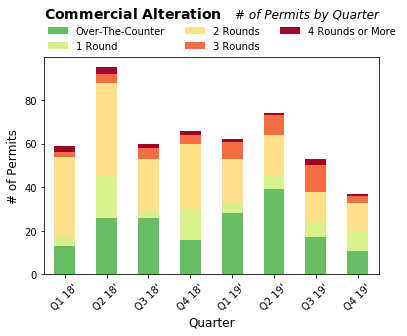

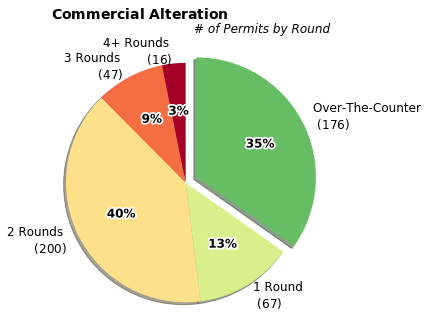

In [11]:
from matplotlib import cm
import matplotlib.pyplot as plt

def Qbar(temp, yy='# of Permits', title=tit):
    yy = '# of Permits' or yy
    title = 'Commercial Alteration' or title
    temp = temp.unstack(level=1)[yy].reindex(list(QQ.values()))
    if list(temp)[-1] == 'Over-The-Counter':
        new_order = ['Over-The-Counter'] + list(temp)[:-1]
        temp = temp[new_order]
    my_colors = reversed(cm.RdYlGn(np.arange(len(list(temp)))/len(list(temp))))
    
    fig, ax = plt.subplots()
    
    
    temp.plot(kind='bar', subplots=False, stacked = True, 
              color=my_colors, ax=ax
                               )
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
            borderaxespad=0, frameon=False)
    ax.set_ylabel(yy, fontsize=12)
    ax.set_xlabel('Quarter', fontsize=12)
    legend_properties = {'weight':'bold'}
    
    ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.15, fontsize=14)
    ax.set_title('{} by Quarter'.format(yy), 
                 loc='right', y=1.15, style='italic')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    fig.savefig('{} - Permits by Quarter.png'.format(title), bbox_inches='tight') 

def Qpie(temp, yy='# of Permits', title=tit):
    yy = '# of Permits' or yy
    title = 'Commercial Alteration' or title
    
    labels = temp.index.to_list()
    labels[-1] = '4+ Rounds'
    labels = [str(l) + ' \n $\mathit{ (' + str(a) + ') }$' for l,a in zip(labels, temp[yy].to_list())]
    
    sizes = [p/sum(temp[yy].to_list()) for p in temp[yy].to_list()]
    explode = [0] * len(labels)
    explode[0] = 0.1

    clr = reversed(cm.RdYlGn(np.arange(len(labels))/len(labels)))

    fig1, ax1 = plt.subplots(figsize=(5,5))
    patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.f%%',
            shadow=True, counterclock=False, startangle=90, colors=clr)
    import matplotlib.patheffects as PathEffects
    for t in texts:
        t.set_fontsize(12)
    for t in autotexts:
        t.set_fontsize(12)
        t.set_weight('bold')
        t.set_path_effects([PathEffects.withStroke(linewidth=3.5, foreground='w')])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    #fig1.suptitle('$\mathbf{' + title.replace(' ', ' \\ ') + '}$ by Rounds (#)')
    ax1.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.075, fontsize=14)
    ax1.set_title('{} by Round'.format(yy), 
                 loc='right', y=1.025, style='italic')
    fig1.savefig('{} - Permits by Round.png'.format(title), bbox_inches='tight') 

    plt.show()    
    
Qbar(BTI_Q)
Qpie(BTI_avg)

Text(1.0, 1.01, 'Cakes by Quarter')

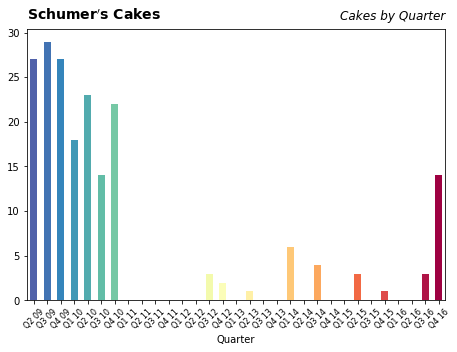

In [4]:
from matplotlib import cm
SCH = pd.read_csv(r"C:\Users\nelms\Downloads\schumer.csv").rename(columns={
    'file_number':'ID',
     'committee_name':'Spender',
     'recipient_name':'Recipient',
     'disbursement_date':'Date',
     'disbursement_amount':'Amount'
})
SCH['Date'] = pd.to_datetime(SCH['Date'])
SCH['Quarter'] = SCH['Date'].dt.to_period('Q')
SCH = pd.DataFrame(SCH.groupby('Quarter')['Amount'].sum().resample('Q').asfreq().fillna(0))

Q = list(SCH.index.unique())
Q.sort()
QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') 
          for e,q in enumerate(Q)}
SCH.index = SCH.index.map(QQ)

SCH['Cakes'] = SCH['Amount'].apply(lambda x: round(x/43.95))

my_colors = reversed(cm.Spectral(np.arange(len(SCH))/len(SCH)))
    
fig, ax = plt.subplots(figsize=(7.5,5))
    
    
SCH['Cakes'].plot(kind='bar', subplots=False, stacked = True, 
              color=my_colors, ax=ax
                               )
for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8) 
ax.set_title('$\mathbf{' + "Schumer's Cakes".replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.01, fontsize=14)
ax.set_title('Cakes by Quarter', 
                 loc='right', y=1.01, style='italic')

In [22]:
def add_to_format(existing_format, dict_of_properties, workbook):
    """Give a format you want to extend and a dict of the properties you want to
    extend it with, and you get them returned in a single format"""
    new_dict={}
    for key, value in existing_format.__dict__.iteritems():
        if (value != 0) and (value != {}) and (value != None):
            new_dict[key]=value
    del new_dict['escapes']

    return(workbook.add_format(dict(new_dict.items() + dict_of_properties.items())))

def box(workbook, sheet_name, row_start, col_start, row_stop, col_stop):
    """Makes an RxC box. Use integers, not the 'A1' format"""

    rows = row_stop - row_start + 1
    cols = col_stop - col_start + 1

    for x in range((rows) * (cols)): # Total number of cells in the rectangle

        box_form = workbook.add_format()   # The format resets each loop
        row = row_start + (x // cols)
        column = col_start + (x % cols)

        if x < (cols):                     # If it's on the top row
            box_form = add_to_format(box_form, {'top':1}, workbook)
        if x >= ((rows * cols) - cols):    # If it's on the bottom row
            box_form = add_to_format(box_form, {'bottom':1}, workbook)
        if x % cols == 0:                  # If it's on the left column
            box_form = add_to_format(box_form, {'left':1}, workbook)
        if x % cols == (cols - 1):         # If it's on the right column
            box_form = add_to_format(box_form, {'right':1}, workbook)

        sheet_name.write(row, column, "", box_form)

In [23]:
#os.chdir(r'O:\CDD\PLANNING\AN\Projects\Accela Reporting')
#BTI_Q.to_csv(r'C:\Users\nelms\Downloads\Quarters.csv')

In [28]:
import datetime

os.chdir(r'O:\CDD\PLANNING\AN\Projects\Accela Reporting')
def colnum_string(n):
    string = ""
    n = n + 1
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

def rng_create(A, one, B, two):
    return str(colnum_string(A)) + str(one) + ":" + str(colnum_string(B)) + str(two)

def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]

def normalize_types(lyr):
        str_list = list(lyr.select_dtypes(include=['datetime','period[Q-DEC]','O']))
        convert_dict = {s:str for s in str_list}
        no_str = [l for l in list(lyr) if l not in str_list]
        no_dict = lyr[no_str].dtypes.to_dict()
        convert_dict.update(no_dict)
        return lyr.astype(convert_dict)

new_path = 'BlueTest_Building_{}.xlsx'.format(tit.replace(' ',''))

import xlsxwriter as xlsx
wrkbk = xlsx.Workbook(new_path)
for OG, name in [(BTI,tit), (BTI_avg, 'Averages'), (BTI_Q, 'Quarterly Averages')]:
    worksheet = wrkbk.add_worksheet(name)
    
    lyr = OG.copy()
    
    lyr = normalize_types(lyr)
    
    header = np.array([[lyr.index.name] + list(lyr)])
    data = lyr.reset_index().to_numpy()
    if data.shape[1] != header.shape[1]:        
        dif = data.shape[1] - header.shape[1]
        fix_head = [lyr.index.name] + list(lyr)
        for r in range(dif):
            fix_head = [' '] + fix_head
        header = np.array([fix_head])
    table = np.vstack((header,data))
    numRows,numColumns = table.shape
    
    idx = [0]
    if type(lyr.index) == pd.MultiIndex:
        idx.append(1)
        table[0,0:2] = list(lyr.index.names)
    else:
        table[0,0:1] = list(lyr.index.names)

    for c in range(numColumns):
        for r in range(numRows):
            format_dict = {'font_name':'Arial'}
            
            # TOP
            if (r == 0) & (c not in idx):
                format_dict['bottom'] = 2
                format_dict['bold'] = True
                format_dict['text_wrap'] = True
            # INDEX NAME
            if (r == 0) & (c in idx):
                format_dict['italic'] = True
            # RIGHT
            elif (r != 0) & (c == range(numColumns)[-1]):
                format_dict['right'] = 2
                if (r == range(numRows)[-1]):
                    format_dict['bottom'] = 2
            # LEFT
            elif (r != 0) & (c in idx):
                format_dict['bold'] = True
                if (1 not in idx)or(c == 1):
                    format_dict['right'] = 2
            # BOTTOM
            elif (r == range(numRows)[-1]) & (c not in idx):
                format_dict['bottom'] = 2
                if (c == range(numColumns)[-1]):
                    format_dict['right'] = 2
            item = table[r][c]
            
            cell_format = wrkbk.add_format(format_dict)
            worksheet.write(r, c, item, cell_format)
        if c not in idx:
            worksheet.set_column(c, c, 10)
        else:
            worksheet.set_column(c, c, len(max(table[:,c], key=len))+1)
            

wrkbk.close()
